# CS156 Assignment LBA 

## Image Pre-processing 

In [1]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt


images = glob("images-jpg/*")
print(len(images))

22


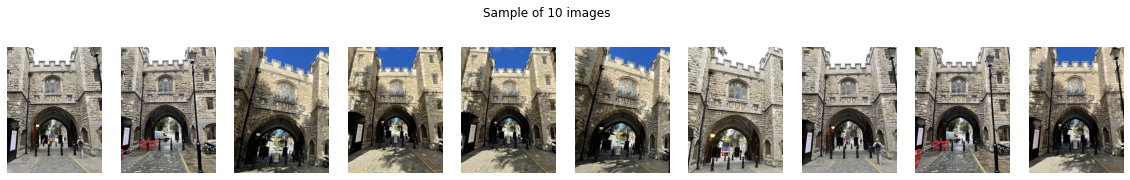

In [2]:
# Check the first few images 
fig, axs = plt.subplots(1,10, figsize = [20,3])
fig.suptitle("Sample of 10 images")

for i in range(len(axs)):   
    with open(images[i], 'r+b') as im:
        with Image.open(im) as f: 
            cover = resizeimage.resize_cover(f, [384, 512])
            axs[i].axis('off')
            axs[i].imshow(cover)



In [3]:
# Define the size of our image pixels (width, height)
size = [384,512]

def image_resize(images, size):
    """
    This function is used from Session 7.1 where we use to 
    resize images. We will be scaling the images to 384 x 512 pixels
    """
    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, size)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))

    # Flatten it once more
    flattened = np.asarray(flattened, dtype = object)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    return X, Y



In [4]:
# Resize image
X, Y = image_resize(images, size)

# Make sure X is in (n_samples, n_features)
print(X.shape)


(22, 589824)


/Users/lancelot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Note: 
This error can be ignored since the arrangement of our list is what is desired (n_samples, n_feautures) and the n_feautures is equal to prod(384, 512, 3). Additionally, we only need to run this function once and therefore we don't need to consider the future repercussions. 

## Testing out the PCA function and visualize on a scree plot

In [5]:
# Implementing PCA 
from sklearn import decomposition

# We will by looking at how much variance we get 
# by using 22 components (max size = n_samples)
n_components = 22

pca = decomposition.PCA(n_components = n_components)
X_fit = pca.fit_transform(X)

print(X_fit.shape)

(22, 22)


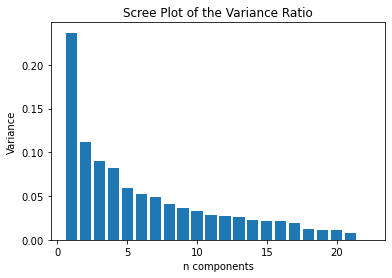

In [6]:
# Plot the variance on a scree plot 
def plot_scree(n_comp, pca_var):
    plt.bar(np.linspace(1, n_comp, n_comp),pca_var)

    plt.title("Scree Plot of the Variance Ratio")
    plt.xlabel("n components")
    plt.ylabel("Variance")

    plt.show()
    
plot_scree(n_components, pca.explained_variance_ratio_)

## Reducing the pictures to 2 dimensions

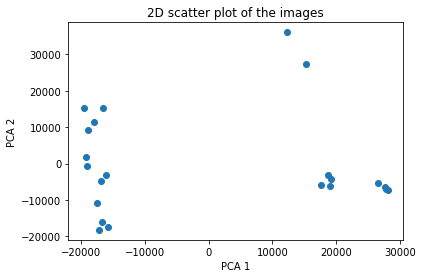

Components shape: (22, 2)


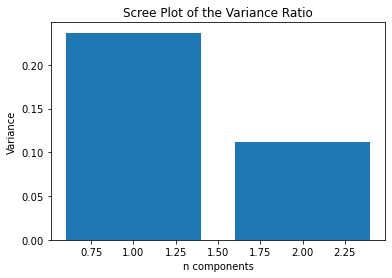

Cumulation of Variance 0.3484876690382187


In [7]:
# Implementing PCA to reduce to 2 dimensions 
from sklearn import decomposition

# Set the n_components = 2 to reduce the data to 2 dimensions 
n_components = 2

pca = decomposition.PCA(n_components = n_components)
X_fit = pca.fit_transform(X)

# Plot 2D sscatterplot 
plt.scatter(X_fit[:, 0], X_fit[:, 1])
plt.title("2D scatter plot of the images")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

print("Components shape:", X_fit.shape)

plot_scree(n_components, pca.explained_variance_ratio_)
print("Cumulation of Variance", np.sum(pca.explained_variance_ratio_))

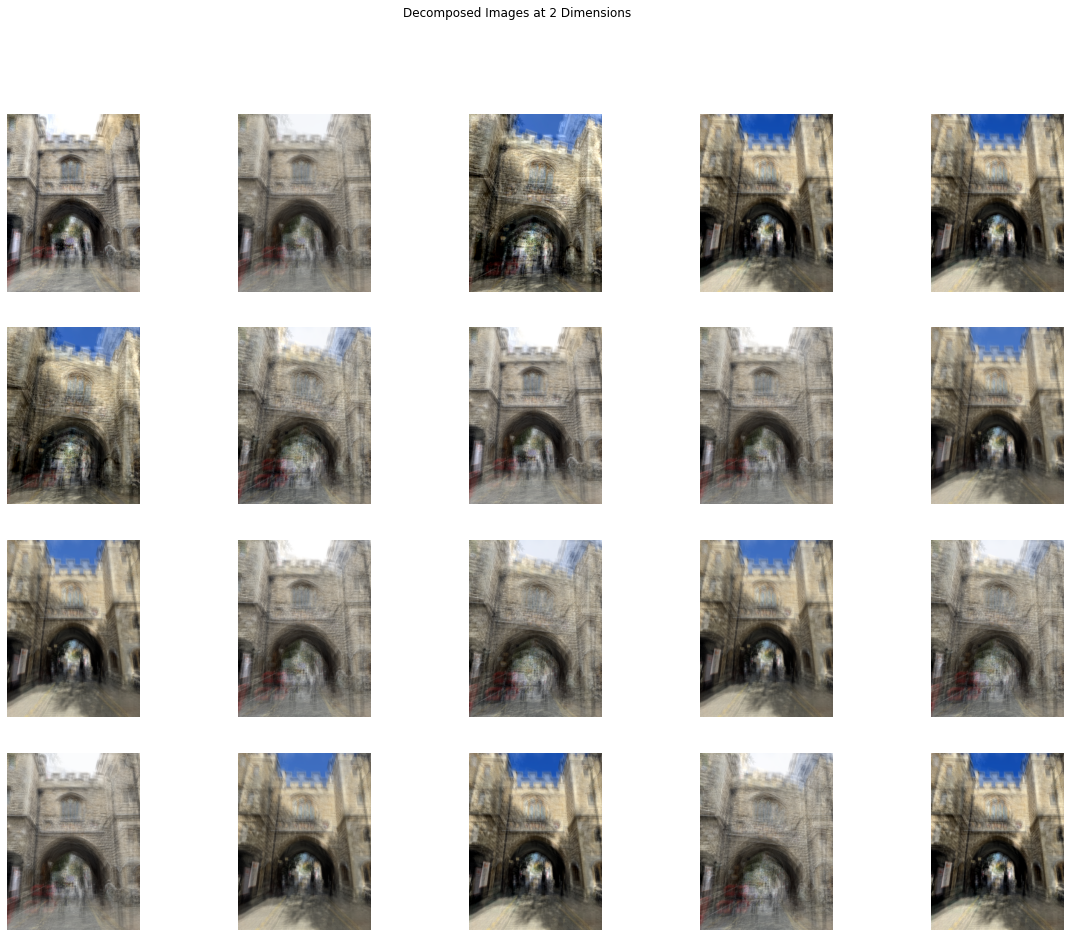

In [8]:
reshape_size = [512, 384, 3]

def inverse_images(X_fitted):
    # inverse the images before plotting 
    images = []
    
    img = pca.inverse_transform(X_fitted)
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    for i in img:
        images.append(Image.fromarray(i.reshape(reshape_size), 'RGB'))
        
    return images

def plot_gallery(images):

    # Check the first few images 
    fig, axs = plt.subplots(4,5, figsize = [20,15])
    fig.suptitle("Decomposed Images at 2 Dimensions")
    
    counter = 0
    
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            axs[i][j].imshow(images[counter])
            axs[i][j].axis("off")
            counter += 1

inv_images = inverse_images(X_fit)
plot_gallery(inv_images)

## Reconstructing Images from varying low-dimensions 

In [9]:
n_comp = [1, 2,4,8,16] #increasing by a factor of 2 

transformed_samples = []
sum_variance = []

for n in n_comp:
    pca = decomposition.PCA(n_components = n)
    X_fit = pca.fit_transform(X)
    
    transformed_samples.append(inverse_images(X_fit))
    sum_variance.append(np.sum(pca.explained_variance_ratio_))
    
len(transformed_samples)

5

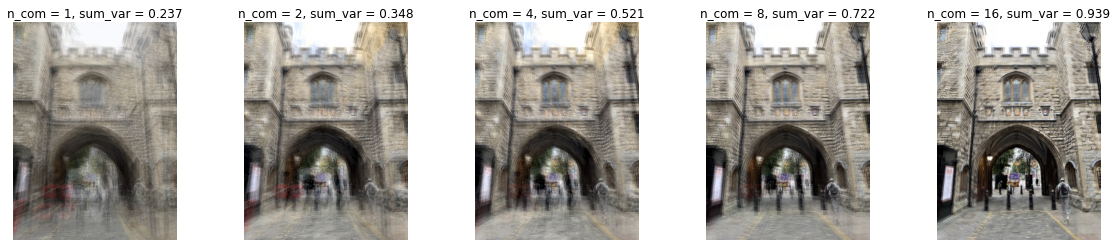

In [10]:
fig, axs = plt.subplots(1,len(n_comp), figsize = [20,4])

for i in range(0,len(n_comp)):
    random_image = transformed_samples[i][0]
    
    axs[i].set_title(f"n_com = {n_comp[i]}, sum_var = {np.round(sum_variance[i],3)}")
    axs[i].axis("off")
    axs[i].imshow(random_image)


## Acquring Far Points in the 2D PCA plot 

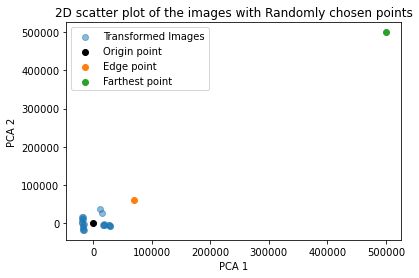

In [11]:
# Set the n_components = 2 to reduce the data to 2 dimensions 
n_components = 2

pca = decomposition.PCA(n_components = n_components)
X_fit = pca.fit_transform(X)

plt.scatter(X_fit[:, 0], X_fit[:, 1], label = 'Transformed Images', alpha = 0.5)
plt.title("2D scatter plot of the images with Randomly chosen points")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Place the randomly chosen points in the dictionary 
# These points were chosen in a matter of going further away
# from the clusters of the points of the images 
rand_points = {"origin": [0,0],
              "edge" : [70000,60000],
              "far_point" : [500000,500000]}

plt.scatter(rand_points["origin"][0], rand_points["origin"][1], label = 'Origin point', c = 'black')
plt.scatter(rand_points["edge"][0], rand_points["edge"][1], label = 'Edge point')
plt.scatter(rand_points["far_point"][0], rand_points["far_point"][1], label = 'Farthest point')

plt.legend()
plt.show()


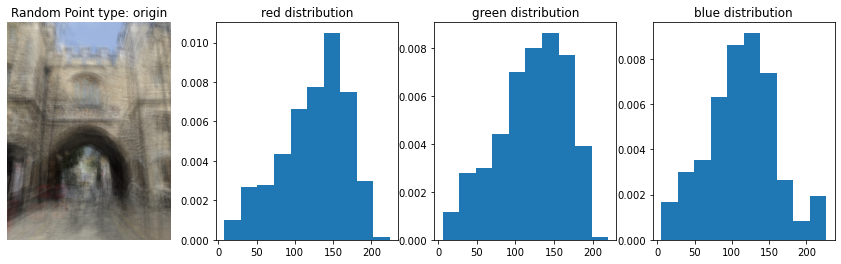

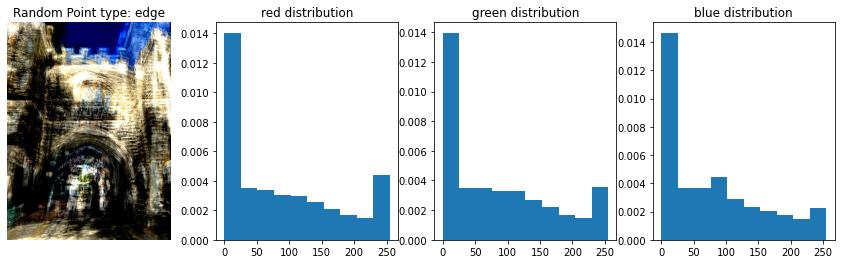

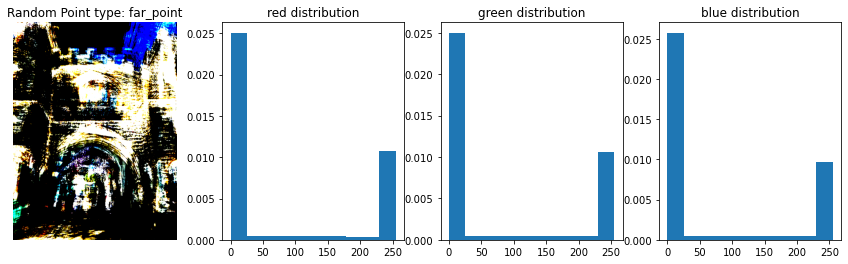

In [12]:
def plot_img(points, cat):
    
    img = pca.inverse_transform(rand_points[cat])
    img = np.clip(img, 0, 255).astype(np.uint8)
    img_rgb = img.reshape(-1, 3)
    img = Image.fromarray(img.reshape(reshape_size), "RGB")
    
    fig, axs = plt.subplots(1,4, figsize = [15,4])
    # Plot image 
    axs[0].set_title(f"Random Point type: {cat}")
    axs[0].axis("off")
    axs[0].imshow(img)
    
    # Plot RGB distributions
    axs[1].set_title("red distribution")
    axs[1].hist(img_rgb[:,0], density = True)
    
    axs[2].set_title("green distribution")
    axs[2].hist(img_rgb[:,1], density = True)
    
    axs[3].set_title("blue distribution")
    axs[3].hist(img_rgb[:,2], density = True)
    
    
plot_img(rand_points, 'origin')
plot_img(rand_points, 'edge')
plot_img(rand_points, 'far_point')